In [ ]:
#notebook doesn't work
#RuntimeError: The size of tensor a (112) must match the size of tensor b (96) at non-singleton dimension 2
https://medium.com/@ssmaameri/ai-generated-qr-codes-with-controlnet-huggingface-and-google-colab-a99ffeee2210

In [ ]:
!pip -q install diffusers transformers accelerate torch xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 5.5 MB/s eta 0:00:00


In [ ]:
import torch
from PIL import Image
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image
import base64
from io import BytesIO

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.1.0+cu118)
    Python  3.10.13 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "DionTimmer/controlnet_qrcode-control_v11p_sd21",
    torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/988 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# pipe.enable_xformers_memory_efficient_attention()
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)


In [ ]:
pipe.enable_model_cpu_offload()

In [ ]:
"""
later will encounter
RuntimeError: The size of tensor a (92) must match the size of tensor b (22) at non-singleton dimension 3
lowered resolution from 768 to 180 to make both QR and base image have same shape cuz it didn't before, but it didn't fix the problem

From
It will fail if the base image provided is not a square, at least approximately, so make sure to use square images only for the base image. Crop it if needed.
"""
def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

def resize_for_condition_image1(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size

    # Choose the target resolution for both width and height
    target_resolution = resolution

    # Calculate the scaling factor based on the target resolution
    k = float(target_resolution) / max(W, H)

    # Scale both width and height by the same factor
    H = int(round(H * k / 64.0)) * 64
    W = int(round(W * k / 64.0)) * 64

    # Resize the image
    img = input_image.resize((W, H), resample=Image.LANCZOS)

    # Crop the image to make it square
    left = (W - target_resolution) // 2
    top = (H - target_resolution) // 2
    right = left + target_resolution
    bottom = top + target_resolution

    img = img.crop((left, top, right, bottom))

    return img

# qr code image
qr_code_image = load_image("/content/instagram.png")
qr_code_image1 = resize_for_condition_image(qr_code_image, 768)
# qr_code_image1 = resize_for_condition_image(qr_code_image, 180)


# base image
base_image = load_image("/content/demo.png")
base_image1 = resize_for_condition_image1(base_image, 768)
# base_image1 = resize_for_condition_image(base_image, 180)


print("original qr code size",qr_code_image.size)
print("base image size",base_image.size)
print("afte reshaping")
print(qr_code_image1.size)
print(base_image1.size)

original qr code size (4200, 4200)
base image size (1672, 934)
afte reshaping
(768, 768)
(768, 768)


  0%|          | 0/120 [00:00<?, ?it/s]

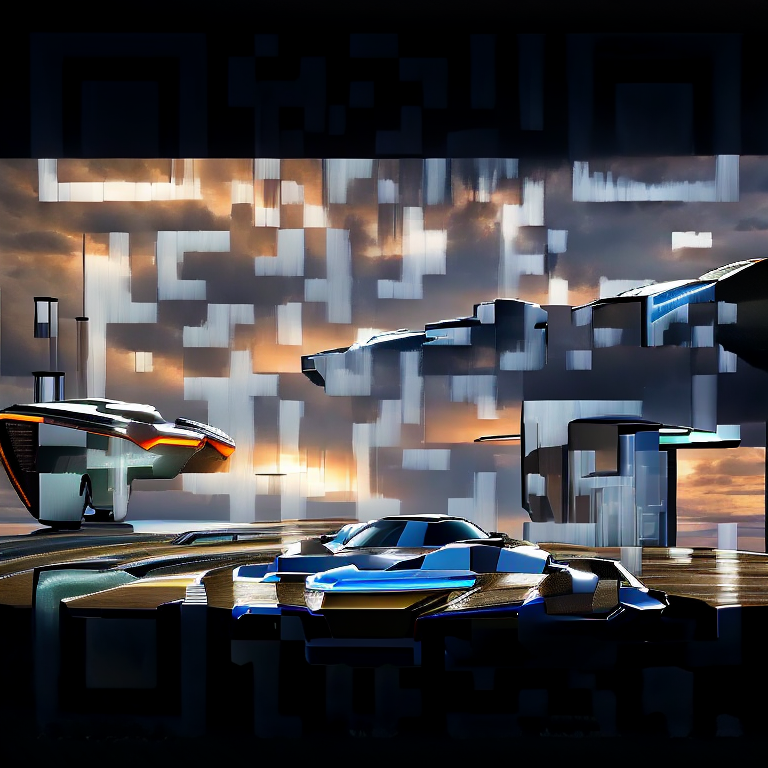

In [ ]:
"""
This a Colab that uses the "DionTimmer/controlnet_qrcode-control_v11p_sd21"
control net model from HuggingFace to generate QR Codes based on base images
and text prompts

HuggingFace link to the model
https://huggingface.co/DionTimmer/controlnet_qrcode-control_v11p_sd21

Medium Article describing this Colab in somre mored detail
https://medium.com/@ssmaameri/ai-generated-qr-codes-with-controlnet-huggingface-and-google-colab-a99ffeee2210

Powerpoint showing affects of different guidance_scale,
controlnet_conditioning_scale and strength values in the model
https://docs.google.com/presentation/d/1spTfvtorPxZ1yQTXH_tkKi32WzbusqbtStXyvlJMShk/edit?usp=sharing

https://me-qr.com/qr-code-generator/qr
For QR Code

"""


# play with guidance_scale, controlnet_conditioning_scale and strength to vary
# the dominance of the QR Code vs the base image and prompt

# Approximate optimal default value
#   guidance_scale = 20,
#   controlnet_conditioning_scale = 2.0,
#   strength = 0.9

generator = torch.manual_seed(123121231)
image = pipe(
    prompt="realistic, 8K",
    negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
    image=base_image1,
    control_image=qr_code_image1,
    width=768,
    height=768,

    guidance_scale=30, #The higher the values, the sharper the final image is, including the QR Code and base image.
    controlnet_conditioning_scale=2.5, #    #This tweaks how strong to make the QR image vs the base image. The images below you can see the results when varying the value between 0–5. At low values, the QR code does not come through at all. At high values, all you can see is the QR code
    # controlnet_conditioning_scale=4.5,

    generator=generator,
    strength=0.8,
    #this also controls how strong the QR code comes through over the base image.
    #At low values the QR code barely comes though. At high values it is much more dominant
    num_inference_steps=150
)

image.images[0]

In [ ]:
base_image = load_image("/content/gf.png")
base_image1 = resize_for_condition_image1(base_image, 768)

  0%|          | 0/135 [00:00<?, ?it/s]

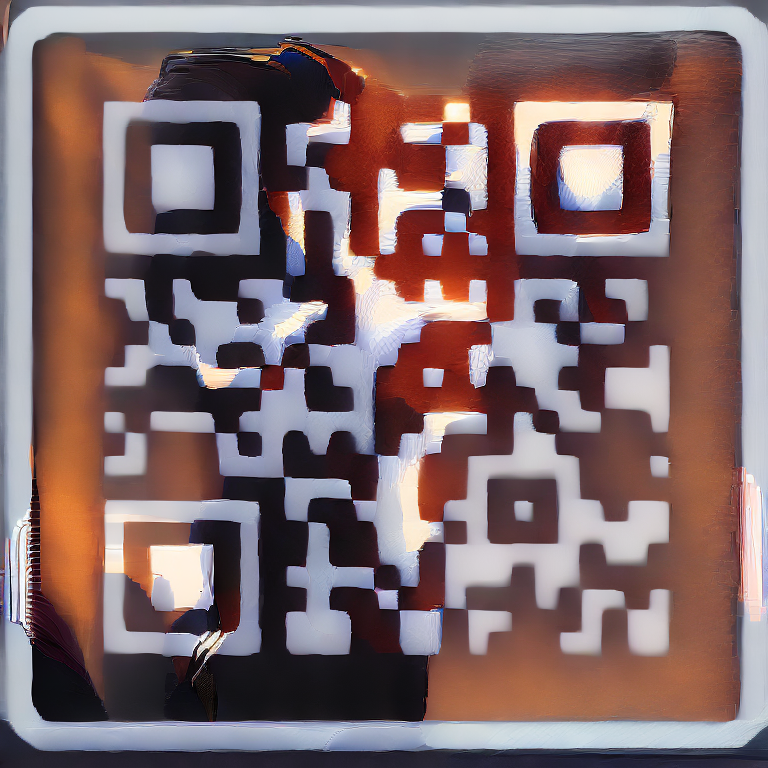

In [ ]:
image = pipe(
    prompt="realistic, 8K, person",
    negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
    image=base_image1,
    control_image=qr_code_image1,
    width=768,
    height=768,

    guidance_scale=30, #The higher the values, the sharper the final image is, including the QR Code and base image.
    # controlnet_conditioning_scale=2.5,
    controlnet_conditioning_scale=4.5,

    #This tweaks how strong to make the QR image vs the base image. The images below you can see the results when varying the value between 0–5. At low values, the QR code does not come through at all. At high values, all you can see is the QR code
    generator=generator,
    strength=0.9,
    #this also controls how strong the QR code comes through over the base image.
    #At low values the QR code barely comes though. At high values it is much more dominant
    num_inference_steps=150
)

image.images[0]

In [ ]:
#finding: control-net qrcode can't perform well with person in the base image, even with prompt including a person.
#Existing artworks out there only have animated girls

In [ ]:
!pip install transformers datasets evaluate -q
!pip install jiwer -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.4 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# from datasets import load_dataset
# from huggingface_hub import list_datasets
# ds = load_dataset("imagenet2012")
# print([dataset.id for dataset in list_datasets()])

FileNotFoundError: ignored

In [ ]:
#https://huggingface.co/blog/blip-2
#https://huggingface.co/models?other=blip-2  #other blip 2 operations
#your session crashed after using all available ram. If I'm interested in access to high-ram runtimes, I need colab pro

break #to prevent this code chunk from being run
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
#CLIP-like image encoder, a Querying Transformer (Q-Former) and a large language model.
"""
The authors initialize the weights of the image encoder and large language model from pre-trained checkpoints and keep them frozen
while training the Querying Transformer, which is a BERT-like Transformer encoder that maps a set of "query tokens" to query embeddings,
which bridge the gap between the embedding space of the image encoder and the large language model.
"""
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
inputs = processor(base_image1, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#https://huggingface.co/docs/peft/task_guides/semantic_segmentation_lora
#Semantic segmentation using LoRA
!pip install transformers accelerate evaluate datasets peft -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

ds = load_dataset("scene_parse_150", split="train[:150]")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
ds = ds.train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

In [ ]:
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:659: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


In [ ]:
from transformers import AutoImageProcessor

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, do_reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)
import numpy as np


def handle_grayscale_image(image):
    np_image = np.array(image)
    if np_image.ndim == 2:
        tiled_image = np.tile(np.expand_dims(np_image, -1), 3)
        return Image.fromarray(tiled_image)
    else:
        return Image.fromarray(np_image)
from PIL import Image


def train_transforms(example_batch):
    images = [jitter(handle_grayscale_image(x)) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [handle_grayscale_image(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs

In [ ]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")


def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        # currently using _compute instead of compute
        # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=image_processor.do_reduce_labels,
        )

        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [ ]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

model = AutoModelForSemanticSegmentation.from_pretrained(
    checkpoint, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)
print_trainable_parameters(model)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.weight', 'decode_head.classifier.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3752694 || all params: 3752694 || trainable%: 100.00


In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 566422 || all params: 4317068 || trainable%: 13.12


In [ ]:
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

base_model.model.segformer.encoder.block.0.0.attention.self.query.bias torch.Size([32])
base_model.model.segformer.encoder.block.0.0.attention.self.query.lora_A.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.query.lora_B.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.value.bias torch.Size([32])
base_model.model.segformer.encoder.block.0.0.attention.self.value.lora_A.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.0.attention.self.value.lora_B.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.query.bias torch.Size([32])
base_model.model.segformer.encoder.block.0.1.attention.self.query.lora_A.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.query.lora_B.default.weight torch.Size([32, 32])
base_model.model.segformer.encoder.block.0.1.attention.self.value.bias torch.Size(

In [ ]:
break#don't run this code
model_name = checkpoint.split("/")[-1]
print("model_name",model_name)#mit-b0 not in https://huggingface.co/api/modelsmodel_id = "segformer-scene-parse-150-lora"
lora_model.save_pretrained(model_id)
training_args = TrainingArguments(
    # output_dir=f"{model_name}-scene-parse-150-lora",
    # output_dir=f"{model_name}-sayakpaul/segformer-b0-scene-parse-150-lora",

    output_dir=f"{model_name}-scene-recognition", #id=aot
    learning_rate=5e-4,
    num_train_epochs=50,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=5,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
)
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()
"""
RepositoryNotFoundError: 404 Client Error. (Request ID: Root=1-654faf0f-23be38f4238b421a43c93a7c;44c3394c-78fb-407a-b8e1-4210f6fbd426)

Repository Not Found for url: https://huggingface.co/api/models/mit-b0-scene-recognition.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.
"""

model_name mit-b0


In [ ]:
model_id = "segformer-scene-parse-150-lora"
lora_model.save_pretrained(model_id)

In [ ]:
!ls -lh {model_id}


total 2.2M
-rw-r--r-- 1 root root  629 Nov 11 16:45 adapter_config.json
-rw-r--r-- 1 root root 2.2M Nov 11 16:45 adapter_model.bin
-rw-r--r-- 1 root root 5.0K Nov 11 16:45 README.md


In [ ]:
from peft import PeftConfig
from peft import LoraConfig, get_peft_model

config = PeftConfig.from_pretrained(model_id)
model = AutoModelForSemanticSegmentation.from_pretrained(
    checkpoint, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

inference_model = PeftModel.from_pretrained(model, model_id)
# inference_model = PEFTModel.from_pretrained(model, model_id)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.weight', 'decode_head.classifier.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: ignored

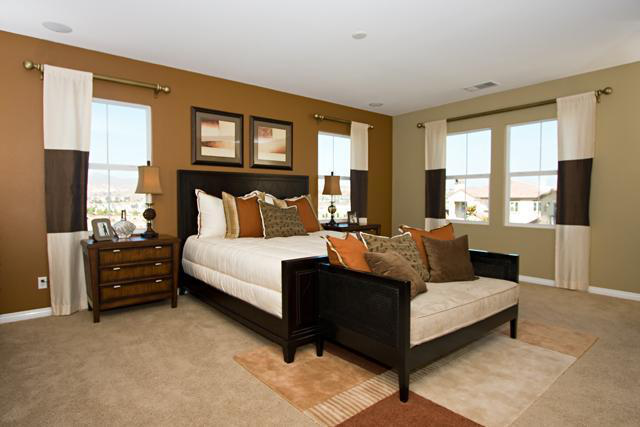

In [ ]:
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/semantic-seg-image.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

In [ ]:
with torch.no_grad():
    outputs = inference_model(pixel_values=encoding.pixel_values)
    logits = outputs.logits

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

NameError: ignored